Imports:

# TODO
# Função para desenhar um ROC chart;
# Função para imprimir info reelativa a accurracy, sensitivity e overfitting measures

# Guia (click to see markdown, easier to read)

Division:
## 1.Classification (dataset 1)
a. Preprocessing (7%)                    => Explore different scenarios and it's repercussions
b. Instance-based Learning (5%)          => KNN
c. Naïve Bayes (5%)
d. Decision Trees (7%)
e. Random Forests (7%)
f. Comparison and critical analysis (15%)  => Depending on the pre-processing and nature of the algorithms discuss the results                                                 and compare them. 

## 2.Non-supervised mining (dataset 2)
a. Preprocessing (8%)
b. Association Rules (8%)
c. Clustering (8%)
d. Comparison and critical analysis (16%)

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import neighbors, model_selection, metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression
import statistics
import graphviz
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from subprocess import check_call
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
import matplotlib.patches as mpatches
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import itertools

c:\users\ines\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ImportError: cannot import name 'KBinsDiscretizer'

### Aux. functions

In [ ]:
def compute_metrics(confusion_matrix):
    #https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)

    # Specificity or true negative rate
    TNR = TN / (TN + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    
    cost = FP * 10 + FN * 500
    #Specific to this example
    return TPR,TNR, cost

def preprocessData(df):
    label_encoder = preprocessing.LabelEncoder()
    dummy_encoder = preprocessing.OneHotEncoder()
    pdf = pd.DataFrame()
    for att in df.columns:
        if df[att].dtype == np.float64 or df[att].dtype == np.int64:
            pdf = pd.concat([pdf, df[att]], axis=1)
        else:
            df[att] = label_encoder.fit_transform(df[att])
            # Fitting One Hot Encoding on train data
            temp = dummy_encoder.fit_transform(df[att].values.reshape(-1,1)).toarray()
            # Changing encoded features into a dataframe with new column names
            temp = pd.DataFrame(temp,
                                columns=[(att + "_" + str(i)) for i in df[att].value_counts().index])
            # In side by side concatenation index values should be same
            # Setting the index values similar to the data frame
            temp = temp.set_index(df.index.values)
            # adding the new One Hot Encoded varibales to the dataframe
            pdf = pd.concat([pdf, temp], axis=1)
    return pdf

def fill_missing_values(dataset, feature_names, class_name = None):
    dataset_preprocessed = dataset.copy()
    
    if class_name == None:
        for feature in feature_names:
            dataset_preprocessed[feature] = dataset_preprocessed.transform(lambda x: x.fillna(x.mean()))[feature]
    else:
        for feature in feature_names:
            dataset_preprocessed[feature] = dataset_preprocessed.groupby(class_name).transform(lambda x: x.fillna(x.mean()))[feature]

    return dataset_preprocessed

# First dataset

## Load data

### Training set - Loading and analysing

In [5]:
aps_train = pd.read_csv("datasets/first/aps_failure_training_set.csv", skiprows=20, na_values = "na", low_memory = False)
#.replace(to_replace='neg', value=False).replace(to_replace='pos', value=True)
feature_names = aps_train.columns[1:].tolist()

X_with_MV = aps_train.iloc[:,1:]
y = aps_train["class"]
labels = pd.unique(y)
y_binary = label_binarize(y, classes=['neg','pos'])
y_binary_reshaped = y_binary.reshape((-1,))

# Test set - loading

In [4]:
aps_test = pd.read_csv("datasets/first/aps_failure_test_set.csv", skiprows=20, na_values = "na", low_memory = False).replace(to_replace='neg', value=False).replace(to_replace='pos', value=True)
X_test = aps_test.iloc[:,1:]
Y_test = aps_test['class']

labels_test = pd.unique(Y_test)
Y_test = label_binarize(Y_test, classes=labels_test)

feature_names_test = aps_test.columns[1:].tolist()

### Training set - preprocessing

In [5]:
#------------------------- REMOVE MVs train ----------------------------

c = "class"
aps_train_filled_mv = fill_missing_values(aps_train, feature_names, c)

X = aps_train_filled_mv.iloc[:,1:]
Y = aps_train_filled_mv['class']
labels = pd.unique(Y)
Y = label_binarize(Y, classes=labels)

In [6]:
#------------------------- REMOVE MVs test ----------------------------

c = "class"
aps_test_filled_mv = fill_missing_values(aps_test, feature_names_test)

X_test = aps_test_filled_mv.iloc[:,1:]
Y_test = aps_test_filled_mv['class']
labels_test = pd.unique(Y_test)
Y_test = label_binarize(Y_test, classes=labels_test)

In [7]:
#----------------- CHECKING BASELINE --------------------------

missing = aps_train_filled_mv.isnull().sum(axis=1)

X_aps_train_filled_mv = aps_train_filled_mv.iloc[:,1:]
y_aps_train_filled_mv = aps_train_filled_mv["class"]

labels = pd.unique(y_aps_train_filled_mv)
labels

array(['neg', 'pos'], dtype=object)

# Pre-processing 1

In [8]:
def normalize (dataset, feature_names):
    dataset_x = dataset.iloc[:,1:]
    dataset_y = dataset['class']
    X_norm = preprocessing.normalize(dataset_x)
    preproc_1 = pd.DataFrame(data=X_norm, columns = feature_names)
    preproc_1.insert(0, "class", dataset_y)
    return preproc_1

In [9]:
result_pre1 = normalize(aps_train_filled_mv, feature_names)

X_preproc_1 = result_pre1.iloc[:,1:]
X_preproc_1.shape

(60000, 170)

# Pre-processing 2

In [10]:
def preproc_2(dataset_original, n, p, c):
    number_observations = dataset_original.shape[0]

    num_dimensions = dataset_original.shape[1] - 1

    non_na_values_threshold = num_dimensions - n * num_dimensions

    aps_train_obs_removed = dataset_original.dropna(thresh=non_na_values_threshold)
    new_number_observations = aps_train_obs_removed.shape[0]
    
    #dataset.info()
    columns = dataset_original.columns
    percent_missing = dataset_original.isnull().sum() * 100 / len(dataset_original)
    missing_value_df = pd.DataFrame({'column_name': columns,
                                     'percent_missing': percent_missing})
                                    
    missing_value_df.sort_values('percent_missing', inplace=True)
    percent_missing = dataset_original.isnull().sum() * 100 / len(dataset_original)

    aps_train_obs_col_removed =  aps_train_obs_removed[aps_train_obs_removed.columns[aps_train_obs_removed.isnull().mean() < p]]
    feature_names_new = aps_train_obs_col_removed.columns[1:].tolist()


    preproc_2 = fill_missing_values(aps_train_obs_col_removed, feature_names_new, "class")

    return preproc_2

In [11]:
result_train = preproc_2(aps_train,0.4, 0.5, 'class')

In [12]:
result_test = preproc_2(aps_test,0.4, 0.5, 'class')

In [13]:
Y_MV_removed = result_train['class']
X_MV_removed = result_train.iloc[:,1:]
Y_MV_removed = label_binarize(Y_MV_removed, classes=['neg','pos']).reshape(-1)

Y_MV_removed_test = result_test['class']
X_MV_removed_test = result_test.iloc[:,1:]
Y_MV_removed_test = label_binarize(Y_MV_removed_test, classes=['neg','pos']).reshape(-1)

X_preproc_2 = X_MV_removed
Y_preproc_2 = Y_MV_removed

X_preproc_2_test = X_MV_removed_test
Y_preproc_2_test = Y_MV_removed_test

# Pre-processing 3

In [14]:
def preproc_3(dataset,feature_names,ratio):

    X = dataset.iloc[:,1:]
    y = dataset["class"]
    y = label_binarize(y, classes=['neg','pos'])

    rus = RandomUnderSampler(sampling_strategy = "majority",random_state=0, ratio = ratio)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    sm = SMOTE(random_state=2)
    X, y = sm.fit_sample(X_resampled, y_resampled.ravel())

    preproc_3 = pd.DataFrame(data=X, columns = feature_names)
    preproc_3.insert(0, "class", y)
    return preproc_3

In [15]:
ratio = 0.033333
result_smote = preproc_3(aps_train_filled_mv, feature_names, ratio)

result_smote.shape

X_preproc_3 = result_smote.iloc[:,1:]
Y_preproc_3 = result_smote['class']

# Pre-processing 4

In [103]:
def preproc_4 (dataset_filled_mv,dataset_filled_mv_test, num_cols):
    
    X_train_filled_mv = dataset_filled_mv.iloc[:,1:]
    X_train_mv_norm = preprocessing.normalize(X_train_filled_mv)
    y_train_filled_mv = dataset_filled_mv.iloc[:,0]
    
    X_test_filled_mv = dataset_filled_mv_test.iloc[:,1:]
    X_test_mv_norm = preprocessing.normalize(X_test_filled_mv)
    y_test_filled_mv = dataset_filled_mv_test.iloc[:,0]
    
    k = len(X_train_filled_mv.columns)
    selector = SelectKBest(score_func=chi2, k=k - num_cols)
    selector.fit(X_train_mv_norm, y_train_filled_mv)
    idxs_selected = selector.get_support(indices=True)
    
    columns = X_train_mv_norm[0][idxs_selected]
    features_dataframe_new = X_train_mv_norm[:,idxs_selected]
    features_dataframe_new_test = X_test_mv_norm[:,idxs_selected]
    
    cols = dataset_filled_mv.iloc[:,1:].columns[idxs_selected]
    preproc_4 = pd.DataFrame(data = features_dataframe_new, columns=cols)
    preproc_4.insert(0, "class", y_train_filled_mv)
    
    preproc_4_test = pd.DataFrame(data = features_dataframe_new_test, columns=cols)
    preproc_4_test.insert(0, "class", y_test_filled_mv)

    return preproc_4, preproc_4_test

In [104]:
result_pre4, result_pre4_test = preproc_4(aps_train_filled_mv,aps_test_filled_mv, 150)

X_preproc_4 = result_pre4.iloc[:,1:]
Y_preproc_4 = result_pre4['class']
Y_preproc_4 = label_binarize(Y_preproc_4, classes=Y_preproc_4.unique())

X_preproc_4_test = result_pre4_test.iloc[:,1:]
Y_preproc_4_test = result_pre4_test['class']
Y_preproc_4_test = label_binarize(Y_preproc_4_test, classes=Y_preproc_4_test.unique())

# ------------------------------------------------- KNN ---------------------------------------------------

In [27]:
n_splits = 5
kf = model_selection.KFold(n_splits = n_splits)
Ks = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,30]
#Ks = [1,3,5,7,9,11,13,15,17,19,21]

accurracies_knn, accurracies_knn_pre1, accurracies_knn_pre2, accurracies_knn_pre3, accurracies_knn_pre4 = [], [], [], [], []
costs_knn, costs_knn_pre1, costs_knn_pre2, costs_knn_pre3, costs_knn_pre4 = [], [], [], [], []
tpr_knn, tpr_knn_pre1, tpr_knn_pre2, tpr_knn_pre3, tpr_knn_pre4 = [], [], [], [], []
fpr_knn, fpr_knn_pre1, fpr_knn_pre2, fpr_knn_pre3, fpr_knn_pre4 = [], [], [], [], []

for k in Ks:
    print("K =",k)
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    
    print("___0___")
    model = knn.fit(X,Y)
    predY = model.predict(X_test)

    cm = metrics.confusion_matrix(Y_test, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test, Y_test)
    fpr, tpr, thresholds = roc_curve(Y_test, predY)
    accurracies_knn.append(accurracy)
    costs_knn.append(cost[0])
    tpr_knn.append(tpr)
    fpr_knn.append(fpr)
    print(cm)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("Acurracy: ", accurracy)
    
    print("___1___")
    
    model = knn.fit(X_preproc_1,Y)
    predY = model.predict(X_test)

    cm = metrics.confusion_matrix(Y_test, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test, Y_test)
    fpr, tpr, thresholds = roc_curve(Y_test, predY)
    accurracies_knn_pre1.append(accurracy)
    costs_knn_pre1.append(cost[0])
    tpr_knn_pre1.append(tpr)
    fpr_knn_pre1.append(fpr)
    print(cm)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("Acurracy: ", accurracy)
    
    print("___2___")
    
    model = knn.fit(X_preproc_2,Y_preproc_2)
    predY = model.predict(X_preproc_2_test)

    cm = metrics.confusion_matrix(Y_preproc_2_test, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_preproc_2_test, Y_preproc_2_test)
    fpr, tpr, thresholds = roc_curve(Y_preproc_2_test, predY)
    accurracies_knn_pre2.append(accurracy)
    costs_knn_pre2.append(cost[0])
    tpr_knn_pre2.append(tpr)
    fpr_knn_pre2.append(fpr)
    print(cm)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("Acurracy: ", accurracy)
    
    print("___3___") 
    
    model = knn.fit(X_preproc_3,Y_preproc_3)
    predY = model.predict(X_test)

    cm = metrics.confusion_matrix(Y_test, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_test, Y_test)
    fpr, tpr, thresholds = roc_curve(Y_test, predY)
    accurracies_knn_pre3.append(accurracy)
    costs_knn_pre3.append(cost[0])
    tpr_knn_pre3.append(tpr)
    fpr_knn_pre3.append(fpr)
    print(cm)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("Acurracy: ", accurracy)
    
    print("___4___") 
    
    model = knn.fit(X_preproc_4,Y_preproc_4)
    predY = model.predict(X_preproc_4_test)

    cm = metrics.confusion_matrix(Y_preproc_4_test, predY,labels=[1, 0])
    Sens, Spec, cost = compute_metrics(cm)
    accurracy = model.score(X_preproc_4_test, Y_preproc_4_test)
    fpr, tpr, thresholds = roc_curve(Y_preproc_4_test, predY)
    accurracies_knn_pre4.append(accurracy)
    costs_knn_pre4.append(cost[0])
    tpr_knn_pre4.append(tpr)
    fpr_knn_pre4.append(fpr)
    print(cm)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("Acurracy: ", accurracy)
    
    print("--------------------------------------------------------------")

K = 1
___0___
[[   77   298]
 [   44 15581]]
Sensitivity: 0.20533333333333334
Specificity: 0.997184
Cost: [149440  24980]
Acurracy:  0.978625
___1___
[[   74   301]
 [   42 15583]]
Sensitivity: 0.19733333333333333
Specificity: 0.997312
Cost: [150920  24010]
Acurracy:  0.9785625
___2___
[[    0     0]
 [  277 15496]]
Sensitivity: nan
Specificity: 0.9824383440055792
Cost: [  2770 138500]
Acurracy:  0.9824383440055792
___3___
[[  111   264]
 [  132 15493]]
Sensitivity: 0.296
Specificity: 0.991552
Cost: [133320  68640]
Acurracy:  0.97525
___4___
[[   73   302]
 [   42 15583]]
Sensitivity: 0.19466666666666665
Specificity: 0.997312
Cost: [151420  24020]
Acurracy:  0.9785
--------------------------------------------------------------
K = 3
___0___
[[   58   317]
 [   32 15593]]
Sensitivity: 0.15466666666666667
Specificity: 0.997952
Cost: [158820  19170]
Acurracy:  0.9781875
___1___
[[   60   315]
 [   24 15601]]
Sensitivity: 0.16
Specificity: 0.998464
Cost: [157740  15150]
Acurracy:  0.978812

[array([0.        , 0.20533333, 1.        ]), array([0.        , 0.15466667, 1.        ]), array([0.        , 0.14933333, 1.        ]), array([0.        , 0.13066667, 1.        ]), array([0.        , 0.12266667, 1.        ]), array([0.   , 0.128, 1.   ]), array([0.   , 0.128, 1.   ]), array([0.        , 0.10933333, 1.        ]), array([0.        , 0.10666667, 1.        ]), array([0.   , 0.096, 1.   ]), array([0.   , 0.096, 1.   ]), array([0.        , 0.10133333, 1.        ]), array([0.   , 0.096, 1.   ]), array([0.   , 0.096, 1.   ]), array([0.        , 0.09066667, 1.        ]), array([0.   , 0.088, 1.   ])]
[array([0.      , 0.002816, 1.      ]), array([0.      , 0.002048, 1.      ]), array([0.      , 0.001664, 1.      ]), array([0.      , 0.001216, 1.      ]), array([0.      , 0.001344, 1.      ]), array([0.      , 0.001216, 1.      ]), array([0.      , 0.001024, 1.      ]), array([0.      , 0.001024, 1.      ]), array([0.      , 0.001152, 1.      ]), array([0.      , 0.001024, 1.   

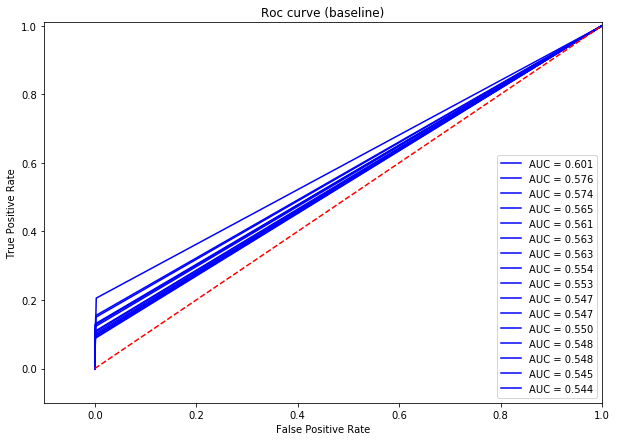

In [32]:
print(tpr_knn)
print(fpr_knn)

roc_aucs_knn_baseline = []
for i in range(0,len(tpr_knn)):
    #roc_aucs_knn_baseline.append(auc(fpr[i],tpr[i]))
    plt.plot(fpr_knn[i], tpr_knn[i], 'b',label='AUC = %0.3f'% auc(fpr_knn[i],tpr_knn[i]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc curve (baseline)")
plt.show()

[array([0.        , 0.19733333, 1.        ]), array([0.  , 0.16, 1.  ]), array([0.        , 0.10666667, 1.        ]), array([0.        , 0.08533333, 1.        ]), array([0.        , 0.06933333, 1.        ]), array([0.        , 0.06666667, 1.        ]), array([0.        , 0.05866667, 1.        ]), array([0.   , 0.048, 1.   ]), array([0.        , 0.05066667, 1.        ]), array([0.        , 0.03733333, 1.        ]), array([0.        , 0.03466667, 1.        ]), array([0.   , 0.032, 1.   ]), array([0.   , 0.016, 1.   ]), array([0.   , 0.016, 1.   ]), array([0.        , 0.01866667, 1.        ]), array([0.        , 0.01066667, 1.        ])]
[array([0.      , 0.002688, 1.      ]), array([0.      , 0.001536, 1.      ]), array([0.0e+00, 9.6e-04, 1.0e+00]), array([0.00e+00, 8.32e-04, 1.00e+00]), array([0.00e+00, 7.04e-04, 1.00e+00]), array([0.00e+00, 7.68e-04, 1.00e+00]), array([0.00e+00, 5.12e-04, 1.00e+00]), array([0.0e+00, 3.2e-04, 1.0e+00]), array([0.00e+00, 2.56e-04, 1.00e+00]), array([0.00

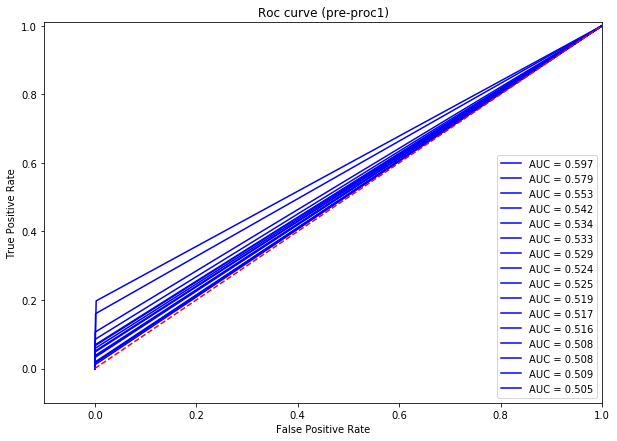

In [33]:
print(tpr_knn_pre1)
print(fpr_knn_pre1)

#roc_aucs_knn_baseline = []
for i in range(0,len(tpr_knn)):
    #roc_aucs_knn_baseline.append(auc(fpr[i],tpr[i]))
    plt.plot(fpr_knn_pre1[i], tpr_knn_pre1[i], 'b',label='AUC = %0.3f'% auc(fpr_knn_pre1[i],tpr_knn_pre1[i]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc curve (pre-proc1)")
plt.show()

[0.978625, 0.9781875, 0.9784375, 0.9784375, 0.978125, 0.978375, 0.9785625, 0.978125, 0.9779375, 0.9778125, 0.9778125, 0.978125, 0.978, 0.977875, 0.9778125, 0.977875]
[0.9785625, 0.9788125, 0.978125, 0.97775, 0.9775, 0.977375, 0.9774375, 0.977375, 0.9775, 0.9773125, 0.9773125, 0.97725, 0.976875, 0.976875, 0.9769375, 0.97675]
[0.9824383440055792, 0.9833259367273188, 0.9846573258099284, 0.985544918531668, 0.9857351169720409, 0.9861155138527864, 0.9866861091739048, 0.9869397070944018, 0.9870665060546504, 0.9875103024155202, 0.9876371013757688, 0.9876371013757688, 0.9876371013757688, 0.9874469029353959, 0.9878272998161415, 0.9880808977366385]
[0.97525, 0.9723125, 0.9695625, 0.9679375, 0.9671875, 0.965375, 0.9644375, 0.96325, 0.9625, 0.9621875, 0.961375, 0.961125, 0.960625, 0.959875, 0.95925, 0.96]


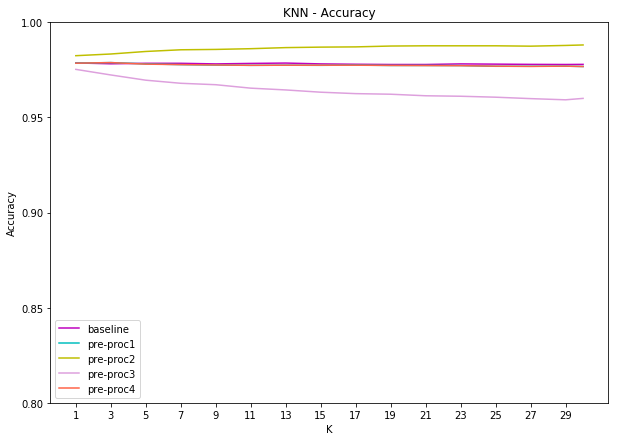

In [101]:
rcParams['figure.figsize'] = 10, 7

print(accurracies_knn)
print(accurracies_knn_pre1)
print(accurracies_knn_pre2)
print(accurracies_knn_pre3)

#accurracies_knn = [0.9888125, 0.989625, 0.9890625, 0.989125, 0.988625, 0.98875, 0.988375, 0.9881875, 0.987875, 0.9876875, 0.9876875, 0.9879375, 0.9880625, 0.987875, 0.9876875, 0.9876875]
#accurracies_knn_pre1 = [0.9380625, 0.9355625, 0.9415, 0.918125, 0.913375, 0.880875, 0.883375, 0.888, 0.883625, 0.8776875, 0.8728125, 0.866125, 0.8421875, 0.842125, 0.856, 0.8639375]

Ks = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,30]
base_knn_acc = plt.plot(Ks, accurracies_knn,'m', label='baseline')
pre1_knn_acc = plt.plot(Ks, accurracies_knn_pre1,'c', label='pre-proc1')
pre2_knn_acc = plt.plot(Ks, accurracies_knn_pre2,'y', label='pre-proc2')
pre2_knn_acc = plt.plot(Ks, accurracies_knn_pre3,'plum', label='pre-proc3')
pre2_knn_acc = plt.plot(Ks, accurracies_knn_pre4,'tomato', label='pre-proc4')
plt.ylabel("Accuracy")
plt.xlabel("K")
plt.xticks(np.arange(1, 31, step=2))

plt.yticks(np.arange(0.8, 1.01, step=0.05))
plt.title("KNN - Accuracy")
plt.xticks
plt.legend()
plt.show()

[149440, 158820, 159760, 163190, 164710, 163690, 163660, 167160, 167680, 169660, 169660, 168630, 169630, 169650, 170640, 171120]
[150920, 157740, 167650, 171630, 174610, 175120, 176580, 178550, 178040, 180520, 181010, 181510, 184510, 184510, 184010, 185510]
[2770, 2630, 2420, 2280, 2250, 2190, 2100, 2060, 2040, 1970, 1950, 1950, 1950, 1980, 1920, 1880]
[133320, 121540, 115610, 110480, 108640, 107460, 107120, 106330, 104980, 103560, 102710, 103240, 102830, 102950, 103050, 102930]


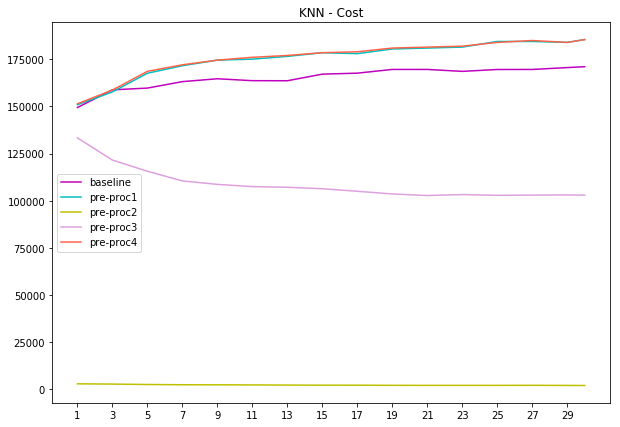

In [72]:
aux_costs_knn,aux_costs_knn_pre1,aux_costs_knn_pre2,aux_costs_knn_pre3 = [], [], [], []

aux_costs_knn = [187730,187660,187500,187510,187500,187500,187500,187500,187500,187500,187500,187500,187500,187500,187500,187500,]
aux_costs_knn_pre1 = [168240,147470,16600,100760,104470,102840,108200,108500,103720,108640,110880,112290,112050,109370,111620,110940]
aux_costs_knn_pre2 = [67940,67320,74770,77690,80210,81680,85160,87160,89180,92160,11190,92130,91130,90650,93140,94120]

'''
for i in range(0,16):
    aux_costs_knn.append(costs_knn[i])
    aux_costs_knn_pre1.append(costs_knn_pre1[i])
    aux_costs_knn_pre2.append(costs_knn_pre2[i])
    aux_costs_knn_pre3.append(costs_knn_pre3[i])
'''
   
print(costs_knn)
print(costs_knn_pre1)
print(costs_knn_pre2)
print(costs_knn_pre3)

plt.plot(Ks, costs_knn,'m',label='baseline')
plt.plot(Ks, costs_knn_pre1,'c', label='pre-proc1')
plt.plot(Ks, costs_knn_pre2,'y', label='pre-proc2')
plt.plot(Ks, costs_knn_pre3,'plum', label='pre-proc3')
plt.plot(Ks, costs_knn_pre4,'tomato', label='pre-proc4')
plt.xticks(np.arange(1, 31, step=2))
plt.title("KNN - Cost")
plt.legend()
plt.show()

[array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan]), array([nan, nan, nan])]
[array([0.        , 0.01756166, 1.        ]), array([0.        , 0.01667406, 1.        ]), array([0.        , 0.01534267, 1.        ]), array([0.        , 0.01445508, 1.        ]), array([0.        , 0.01426488, 1.        ]), array([0.        , 0.01388449, 1.        ]), array([0.        , 0.01331389, 1.        ]), array([0.        , 0.01306029, 1.        ]), array([0.        , 0.01293349, 1.        ]), array([0.       , 0.0124897, 1.       ]), array([0.       , 0.0123629, 1.       ]), array([0.       , 0.0123629, 1.       ]), array([0.       , 0.0123629, 1.       ]), array([0.       , 0.0125531, 1.       ]),

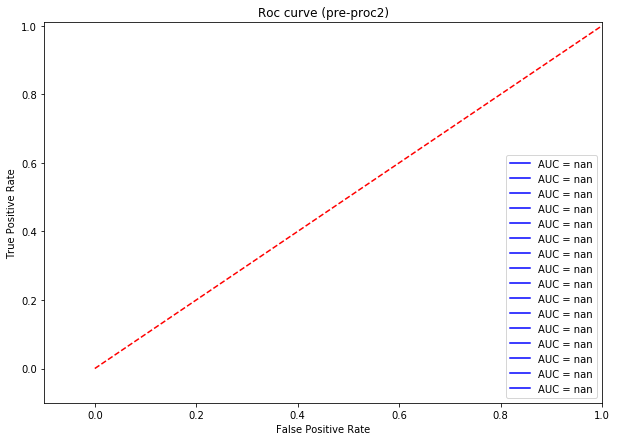

In [58]:
print(tpr_knn_pre2)
print(fpr_knn_pre2)

for i in range(0,len(fpr_knn_pre2)):
    plt.plot(fpr_knn_pre2[i], tpr_knn_pre2[i], 'b',label='AUC = %0.3f'% auc(fpr_knn_pre2[i],tpr_knn_pre2[i]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc curve (pre-proc2)")
plt.show()

[array([0.   , 0.296, 1.   ]), array([0.        , 0.36266667, 1.        ]), array([0.        , 0.39733333, 1.        ]), array([0.        , 0.42666667, 1.        ]), array([0.        , 0.43733333, 1.        ]), array([0.        , 0.44533333, 1.        ]), array([0.   , 0.448, 1.   ]), array([0.        , 0.45333333, 1.        ]), array([0.        , 0.46133333, 1.        ]), array([0.        , 0.46933333, 1.        ]), array([0.        , 0.47466667, 1.        ]), array([0.   , 0.472, 1.   ]), array([0.        , 0.47466667, 1.        ]), array([0.        , 0.47466667, 1.        ]), array([0.        , 0.47466667, 1.        ]), array([0.        , 0.47466667, 1.        ])]
[array([0.      , 0.008448, 1.      ]), array([0.      , 0.013056, 1.      ]), array([0.      , 0.016704, 1.      ]), array([0.      , 0.019072, 1.      ]), array([0.      , 0.020096, 1.      ]), array([0.      , 0.022144, 1.      ]), array([0.      , 0.023168, 1.      ]), array([0.      , 0.024512, 1.      ]), array([0.  

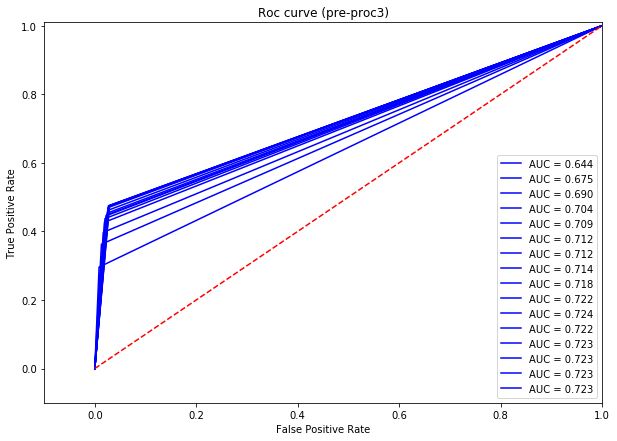

In [59]:
print(tpr_knn_pre3)
print(fpr_knn_pre3)

for i in range(0,len(fpr_knn_pre3)):
    plt.plot(fpr_knn_pre3[i], tpr_knn_pre3[i], 'b',label='AUC = %0.3f'% auc(fpr_knn_pre3[i],tpr_knn_pre3[i]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc curve (pre-proc3)")
plt.show()

[array([0.        , 0.19466667, 1.        ]), array([0.        , 0.15466667, 1.        ]), array([0.        , 0.10133333, 1.        ]), array([0.        , 0.08266667, 1.        ]), array([0.        , 0.06933333, 1.        ]), array([0.        , 0.06133333, 1.        ]), array([0.   , 0.056, 1.   ]), array([0.   , 0.048, 1.   ]), array([0.        , 0.04533333, 1.        ]), array([0.        , 0.03466667, 1.        ]), array([0.   , 0.032, 1.   ]), array([0.        , 0.02933333, 1.        ]), array([0.        , 0.01866667, 1.        ]), array([0.        , 0.01333333, 1.        ]), array([0.        , 0.01866667, 1.        ]), array([0.        , 0.01066667, 1.        ])]
[array([0.      , 0.002688, 1.      ]), array([0.      , 0.001408, 1.      ]), array([0.0e+00, 9.6e-04, 1.0e+00]), array([0.00e+00, 7.68e-04, 1.00e+00]), array([0.0e+00, 6.4e-04, 1.0e+00]), array([0.0e+00, 6.4e-04, 1.0e+00]), array([0.00e+00, 4.48e-04, 1.00e+00]), array([0.00e+00, 2.56e-04, 1.00e+00]), array([0.00e+00, 1.9

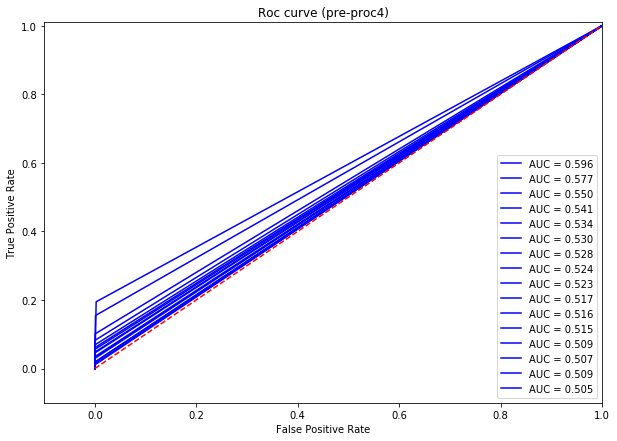

In [40]:
print(tpr_knn_pre4)
print(fpr_knn_pre4)

for i in range(0,len(fpr_knn_pre3)):
    plt.plot(fpr_knn_pre4[i], tpr_knn_pre4[i], 'b',label='AUC = %0.3f'% auc(fpr_knn_pre4[i],tpr_knn_pre4[i]))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc curve (pre-proc4)")
plt.show()

In [ ]:
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

# ------------------------------------------- Naive Bayes -------------------------------------

In [19]:
gnb = GaussianNB()

print("--- BASELINE ---")

model = gnb.fit(X,Y)
predYNB = model.predict(X_test)
cm = metrics.confusion_matrix(Y_test, predYNB,labels=[1, 0])
Sens, Spec, cost = compute_metrics(cm)
accurracy_NB_baseline = model.score(X_test, Y_test)
sensitivity_NB_baseline = Sens[0]
cost_NB_baseline = cost[0]
print(cm)
print("Sensitivity NB Baseline:", sensitivity_NB_baseline)
print("Specificity NB Baseline:", Spec[0])
print("Cost NB Baseline:", cost_NB_baseline)
print("Acurracy NB Baseline:", accurracy_NB_baseline)

print("--- PRE-1 ---")

model = gnb.fit(X_preproc_1,Y)
predYNB = model.predict(X_test)
cm = metrics.confusion_matrix(Y_test, predYNB,labels=[1, 0])
Sens, Spec, cost = compute_metrics(cm)
accurracy_NB_pre1 = model.score(X_test, Y_test)
sensitivity_NB_pre1 = Sens[0]
cost_NB_pre1 = cost[0]
print(cm)
print("Sensitivity NB pre1:", sensitivity_NB_pre1)
print("Specificity NB pre1:", Spec[0])
print("Cost NB pre1:", cost_NB_pre1)
print("Acurracy NB pre1:", accurracy_NB_pre1)

print("--- PRE-2 ---")
model = gnb.fit(X_preproc_2,Y_preproc_2)
predYNB = model.predict(X_preproc_2_test)
cm = metrics.confusion_matrix(Y_preproc_2_test, predYNB,labels=[1, 0])
Sens, Spec, cost = compute_metrics(cm)
accurracy_NB_pre2 = model.score(X_preproc_2_test, Y_preproc_2_test)
sensitivity_NB_pre2 = Sens[0]
cost_NB_pre2 = cost[0]
print(cm)
print("Sensitivity NB pre2:", sensitivity_NB_pre2)
print("Specificity NB pre2:", Spec[0])
print("Cost NB pre2:", cost_NB_pre2)
print("Acurracy NB pre2:", accurracy_NB_pre2)

print("--- PRE-3 ---")

model = gnb.fit(X_preproc_3,Y_preproc_3)
predYNB = model.predict(X_test)
cm = metrics.confusion_matrix(Y_test, predYNB,labels=[1, 0])
Sens, Spec, cost = compute_metrics(cm)
accurracy_NB_pre3 = model.score(X_test, Y_test)
sensitivity_NB_pre3 = Sens[0]
cost_NB_pre3 = cost[0]
print(cm)
print("Sensitivity NB pre3:", sensitivity_NB_pre3)
print("Specificity NB pre3:", Spec[0])
print("Cost NB pre3:", cost_NB_pre3)
print("Acurracy NB pre3:", accurracy_NB_pre3)

print("--- PRE-4 ---")
model = gnb.fit(X_preproc_4,Y_preproc_4)
predYNB = model.predict(X_preproc_4_test)
cm = metrics.confusion_matrix(Y_preproc_4_test, predYNB,labels=[1, 0])
Sens, Spec, cost = compute_metrics(cm)
accurracy_NB_pre4 = model.score(X_preproc_4_test, Y_preproc_4_test)
sensitivity_NB_pre4 = Sens[0]
cost_NB_pre4 = cost[0]
print(cm)
print("Sensitivity NB pre2:", sensitivity_NB_pre4)
print("Specificity NB pre2:", Spec[0])
print("Cost NB pre2:", cost_NB_pre4)
print("Acurracy NB pre2:", accurracy_NB_pre4)



--- BASELINE ---
[[  338    37]
 [  477 15148]]
Sensitivity NB Baseline: 0.9013333333333333
Specificity NB Baseline: 0.969472
Cost NB Baseline: 23270
Acurracy NB Baseline: 0.967875
--- PRE-1 ---
[[  235   140]
 [  644 14981]]
Sensitivity NB pre1: 0.6266666666666667
Specificity NB pre1: 0.958784
Cost NB pre1: 76440
Acurracy NB pre1: 0.951
--- PRE-2 ---
[[    0     0]
 [  784 14989]]
Sensitivity NB pre2: nan
Specificity NB pre2: 0.9502948075825778
Cost NB pre2: 7840
Acurracy NB pre2: 0.9502948075825778
--- PRE-3 ---
[[  338    37]
 [  480 15145]]
Sensitivity NB pre3: 0.9013333333333333
Specificity NB pre3: 0.96928
Cost NB pre3: 23300
Acurracy NB pre3: 0.9676875
--- PRE-4 ---
[[  320    55]
 [ 1870 13755]]
Sensitivity NB pre2: 0.8533333333333334
Specificity NB pre2: 0.88032
Cost NB pre2: 46200
Acurracy NB pre2: 0.8796875


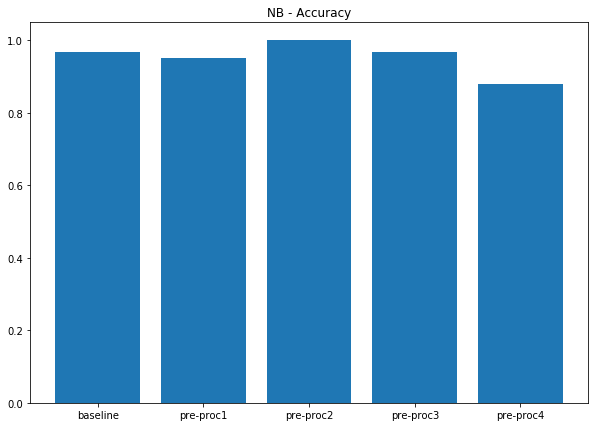

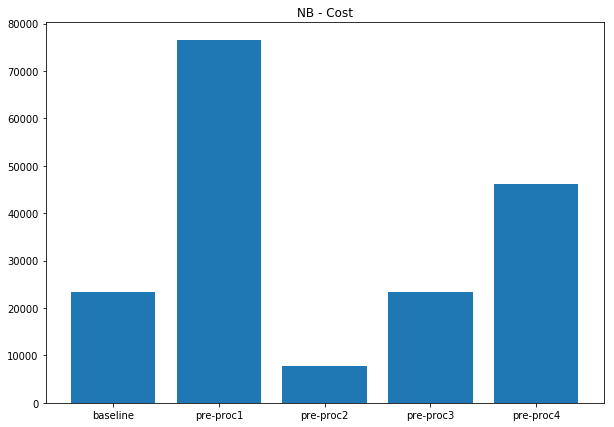

In [73]:
accurracy_NB_pre2 = 1
plt.figure()
plt.bar(["baseline","pre-proc1","pre-proc2","pre-proc3","pre-proc4"],[accurracy_NB_baseline,accurracy_NB_pre1,accurracy_NB_pre2,accurracy_NB_pre3,accurracy_NB_pre4])
plt.title("NB - Accuracy")
plt.show()

accurracy_NB_pre2 = 1
plt.figure()
plt.bar(["baseline","pre-proc1","pre-proc2","pre-proc3","pre-proc4"],[cost_NB_baseline,cost_NB_pre1,cost_NB_pre2,cost_NB_pre3,cost_NB_pre4])
plt.title("NB - Cost")
plt.show()

# C4.5 (decision tree)


varying max_depth

In [105]:
depths = range(1,21)

accurracies_DT_depth = []
costs_DT_depth = []
sensitivities_DT_depth = []

accurracies_DT_depth_pre2 = []
costs_DT_depth_pre2 = []
sensitivities_DT_depth_pre2 = []

accurracies_DT_depth_pre4= []
costs_DT_depth_pre4 = []
sensitivities_DT_depth_pre4= []

for depth in depths:
    
    print("max_depth =", depth)
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    
    model = clf.fit(X, Y)
    predYClf = model.predict(X_test)
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_depth.append(accuracy)
    costs_DT_depth.append(cost[0])
    sensitivities_DT_depth.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    '''
    print("---1---")
    
    model = clf.fit(X_preproc_1, Y)
    predYClf = model.predict(X_test)
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_depth_pre1.append(accuracy)
    costs_DT_depth_pre1.append(cost[0])
    sensitivities_DT_depth_pre1.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    '''
    print("---2---")
    
    model = clf.fit(X_MV_removed, Y_MV_removed)
    predYClf = model.predict(X_preproc_2_test)
    cmClf = metrics.confusion_matrix(Y_preproc_2_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_2_test, Y_preproc_2_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_depth_pre2.append(accuracy)
    costs_DT_depth_pre2.append(cost[0])
    sensitivities_DT_depth_pre2.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    '''
    print("---3---")
    
    model = clf.fit(X_preproc_3, Y_preproc_3)
    predYClf = model.predict(X_test)
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_depth_pre3.append(accuracy)
    costs_DT_depth_pre3.append(cost[0])
    sensitivities_DT_depth_pre3.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    '''
    
    print("---4---")
    model = clf.fit(X_preproc_4, Y_preproc_4)
    predYClf = model.predict(X_preproc_4_test)
    cmClf = metrics.confusion_matrix(Y_preproc_4_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_4_test, Y_preproc_4_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_depth_pre4.append(accuracy)
    costs_DT_depth_pre4.append(cost[0])
    sensitivities_DT_depth_pre4.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    print("--------------------------------------------------------------")
print("Accuracies baseline: ", accurracies_DT_depth)
print("Costs baseline: ", costs_DT_depth)
print("Sensitivities baseline: ", sensitivities_DT_depth)
print("Accuracies pre2: ", accurracies_DT_depth_pre2)
print("Costs pre2: ", costs_DT_depth_pre2)
print("Sensitivities pre2: ", sensitivities_DT_depth_pre2)
print("Accuracies pre4: ", accurracies_DT_depth_pre4)
print("Costs pre4: ", costs_DT_depth_pre4)
print("Sensitivities pre4: ", sensitivities_DT_depth_pre4)

max_depth = 1
[[    3   372]
 [   10 15615]]
Accurracy: 0.976125
Sensitivity: 0.008
Specificity: 0.99936
Cost: [186100   8720]
---2---
[[    0     0]
 [    3 15770]]
Accurracy: 0.9998098015596272
Sensitivity: nan
Specificity: 0.9998098015596272
Cost: [  30 1500]
---4---
[[    0   375]
 [    0 15625]]
Accurracy: 0.9765625
Sensitivity: 0.0
Specificity: 1.0
Cost: [187500   3750]
--------------------------------------------------------------
max_depth = 2
[[   18   357]
 [    8 15617]]
Accurracy: 0.9771875
Sensitivity: 0.048
Specificity: 0.999488
Cost: [178580   7570]
---2---
[[    0     0]
 [  213 15560]]
Accurracy: 0.9864959107335319
Sensitivity: nan
Specificity: 0.9864959107335319
Cost: [  2130 106500]
---4---
[[   10   365]
 [   36 15589]]
Accurracy: 0.9749375
Sensitivity: 0.02666666666666667
Specificity: 0.997696
Cost: [182860  21650]
--------------------------------------------------------------
max_depth = 3
[[   47   328]
 [    6 15619]]
Accurracy: 0.979125
Sensitivity: 0.125333333

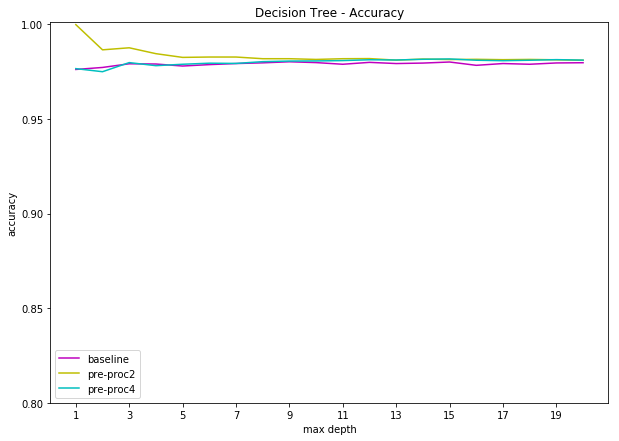

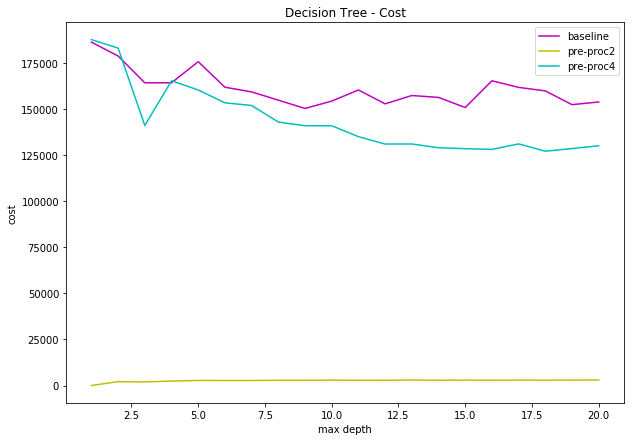

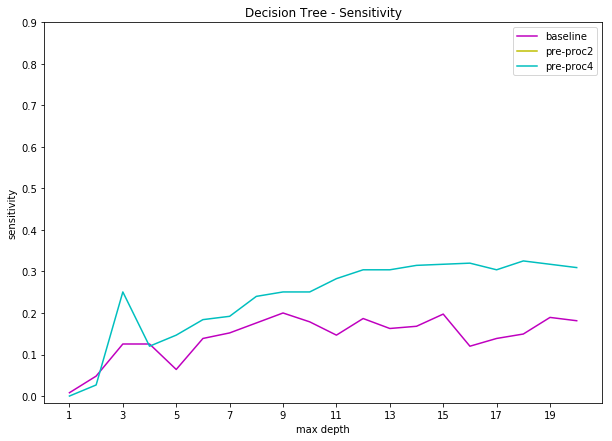

In [107]:
Ks = range(1, 21)

plt.figure()
plt.title('Decision Tree - Accuracy')
plt.plot(Ks, accurracies_DT_depth,'m', label='baseline')
plt.plot(Ks, accurracies_DT_depth_pre2,'y', label='pre-proc2')
plt.plot(Ks, accurracies_DT_depth_pre4,'c', label='pre-proc4')
plt.legend()
plt.xlabel("max depth")
plt.ylabel("accuracy")
plt.xticks(np.arange(1, 20, step=2))
plt.yticks(np.arange(0.8, 1.01, step=0.05))
plt.show()

plt.figure()
plt.title('Decision Tree - Cost')
plt.plot(Ks, costs_DT_depth,'m', label='baseline')
plt.plot(Ks, costs_DT_depth_pre2,'y', label='pre-proc2')
plt.plot(Ks, costs_DT_depth_pre4,'c', label='pre-proc4')
plt.legend()
plt.xlabel("max depth")
plt.ylabel("cost")
plt.show()

plt.figure()
plt.title('Decision Tree - Sensitivity')
plt.plot(Ks, sensitivities_DT_depth,'m', label='baseline')
plt.plot(Ks, sensitivities_DT_depth_pre2,'y', label='pre-proc2')
plt.plot(Ks, sensitivities_DT_depth_pre4,'c', label='pre-proc4')
plt.xlabel("max depth")
plt.ylabel("sensitivity")
plt.xticks(np.arange(1, 20, step=2))
plt.yticks(np.arange(0, 1, step=0.1))
plt.legend()
plt.show()

In [ ]:
splits = range(2,21,2)

accurracies_DT_poda0 = []
costs_DT_poda0 = []
sensitivities_DT_poda0 = []

accurracies_DT_poda2 = []
costs_DT_poda2 = []
sensitivities_DT_poda2 = []

accurracies_DT_poda4 = []
costs_DT_poda4 = []
sensitivities_DT_poda4 = []

accurracies_DT_0 = []
costs_DT_0 = []
sensitivities_DT_0 = []

accurracies_DT_2 = []
costs_DT_2 = []
sensitivities_DT_2 = []

accurracies_DT_4 = []
costs_DT_4 = []
sensitivities_DT_4 = []

for split in splits:
    print(split)
    print("---0 s/poda---")
    clf = tree.DecisionTreeClassifier(min_samples_split=split)
    model = clf.fit(X, Y)
    predYClf = model.predict(X_test)
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_0.append(accuracy)
    costs_DT_0.append(cost[0])
    sensitivities_DT_0.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---0 c/poda---")
    clf = tree.DecisionTreeClassifier(max_depth=2,min_samples_split=split)
    model = clf.fit(X, Y)
    predYClf = model.predict(X_test)
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_poda0.append(accuracy)
    costs_DT_poda0.append(cost[0])
    sensitivities_DT_poda0.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---2 s/poda---")
    
    clf = tree.DecisionTreeClassifier(min_samples_split=split)
    model = clf.fit(X_preproc_2, Y_preproc_2)
    predYClf = model.predict(X_preproc_2_test)
    cmClf = metrics.confusion_matrix(Y_preproc_2_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_2_test, Y_preproc_2_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_2.append(accuracy)
    costs_DT_2.append(cost[0])
    sensitivities_DT_2.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---2 c/poda---")
    
    clf = tree.DecisionTreeClassifier(max_depth=2,min_samples_split=split)
    model = clf.fit(X_preproc_2, Y_preproc_2)
    predYClf = model.predict(X_preproc_2_test)
    cmClf = metrics.confusion_matrix(Y_preproc_2_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_2_test, Y_preproc_2_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_poda2.append(accuracy)
    costs_DT_poda2.append(cost[0])
    sensitivities_DT_poda2.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    
    print("---4 s/poda---")
    
    clf = tree.DecisionTreeClassifier(min_samples_split=split)
    model = clf.fit(X_preproc_4, Y_preproc_4)
    predYClf = model.predict(X_preproc_4_test)
    cmClf = metrics.confusion_matrix(Y_preproc_4_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_4_test, Y_preproc_4_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_4.append(accuracy)
    costs_DT_4.append(cost[0])
    sensitivities_DT_4.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---2 c/poda---")
    
    clf = tree.DecisionTreeClassifier(max_depth=2,min_samples_split=split)
    model = clf.fit(X_preproc_4, Y_preproc_4)
    predYClf = model.predict(X_preproc_4_test)
    cmClf = metrics.confusion_matrix(Y_preproc_4_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_4_test, Y_preproc_4_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_DT_poda4.append(accuracy)
    costs_DT_poda4.append(cost[0])
    sensitivities_DT_poda4.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("--------------------------------------------------------------")
print("Accuracies 0: ", accurracies_DT_0)
print("Costs 0: ", costs_DT_0)
print("Sensitivities 0: ", sensitivities_DT_0)

print("Accuracies 2: ", accurracies_DT_2)
print("Costs 2: ", costs_DT_2)
print("Sensitivities 2: ", sensitivities_DT_2)

print("Accuracies 4: ", accurracies_DT_4)
print("Costs 4: ", costs_DT_4)
print("Sensitivities 4: ", sensitivities_DT_4)

print("Accuracies poda0: ", accurracies_DT_poda0)
print("Costs poda0: ", costs_DT_poda0)
print("Sensitivities poda0: ", sensitivities_DT_poda0)

print("Accuracies poda1: ", accurracies_DT_poda2)
print("Costs poda1: ", costs_DT_poda2)
print("Sensitivities poda1: ", sensitivities_DT_poda2)

print("Accuracies poda4: ", accurracies_DT_poda4)
print("Costs poda4: ", costs_DT_poda4)
print("Sensitivities poda4: ", sensitivities_DT_poda4)

2
---0 s/poda---
[[   68   307]
 [   20 15605]]
Accurracy: 0.9795625
Sensitivity: 0.18133333333333335
Specificity: 0.99872
Cost: [153700  13070]
---0 c/poda---
[[   18   357]
 [    8 15617]]
Accurracy: 0.9771875
Sensitivity: 0.048
Specificity: 0.999488
Cost: [178580   7570]
---2 s/poda---
[[    0     0]
 [  303 15470]]
Accurracy: 0.9807899575223483
Sensitivity: nan
Specificity: 0.9807899575223483
Cost: [  3030 151500]
---2 c/poda---
[[    0     0]
 [  213 15560]]
Accurracy: 0.9864959107335319
Sensitivity: nan
Specificity: 0.9864959107335319
Cost: [  2130 106500]
---4 s/poda---
[[  126   249]
 [   46 15579]]
Accurracy: 0.9815625
Sensitivity: 0.336
Specificity: 0.997056
Cost: [124960  25490]
---2 c/poda---
[[   10   365]
 [   36 15589]]
Accurracy: 0.9749375
Sensitivity: 0.02666666666666667
Specificity: 0.997696
Cost: [182860  21650]
--------------------------------------------------------------
4
---0 s/poda---
[[   60   315]
 [   19 15606]]
Accurracy: 0.979125
Sensitivity: 0.16
Specific

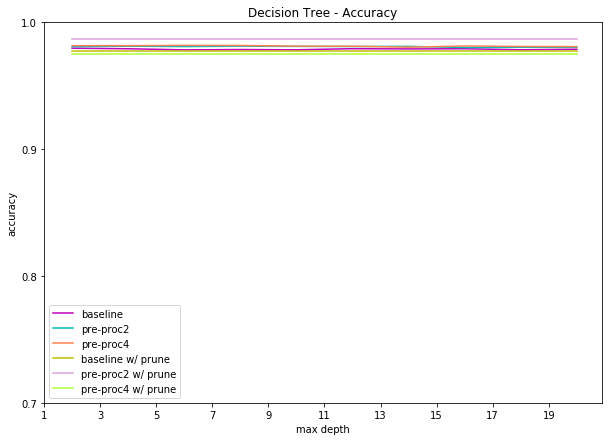

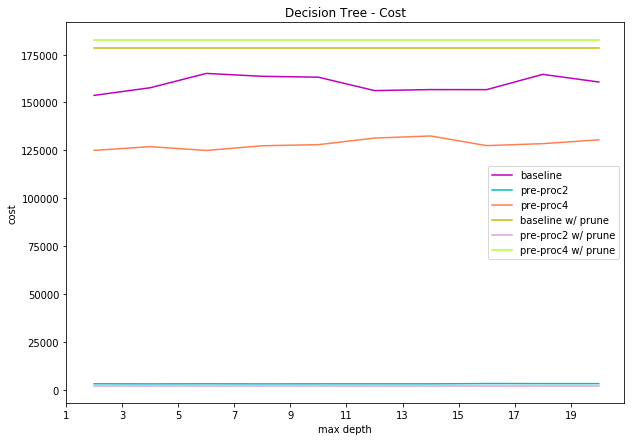

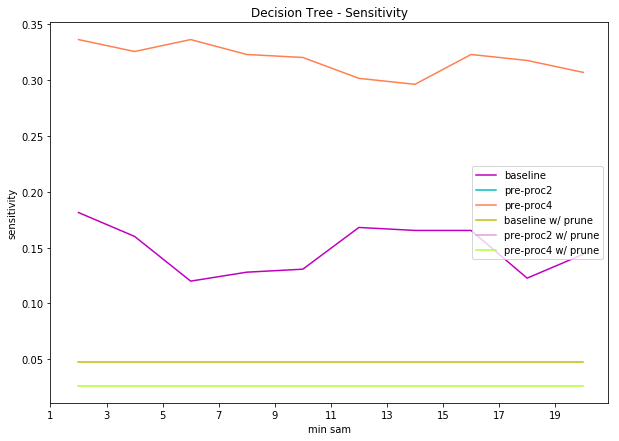

In [109]:
Ks = range(2,21,2)

#accurracies_DT_0[2] = accurracies_DT_0[1]
#costs_DT_0[2] = costs_DT_0[1]
#sensitivities_DT_0[2] = sensitivities_DT_0[1]

plt.figure()
plt.title('Decision Tree - Accuracy')
plt.plot(Ks, accurracies_DT_0,'m', label='baseline')
plt.plot(Ks, accurracies_DT_2,'c', label='pre-proc2')
plt.plot(Ks, accurracies_DT_4,'coral', label='pre-proc4')
plt.plot(Ks, accurracies_DT_poda0,'y', label='baseline w/ prune')
plt.plot(Ks, accurracies_DT_poda2,'plum', label='pre-proc2 w/ prune')
plt.plot(Ks, accurracies_DT_poda4,'greenyellow', label='pre-proc4 w/ prune')
plt.legend()
plt.xlabel("max depth")
plt.ylabel("accuracy")
plt.xticks(np.arange(1, 21, step=2))
plt.yticks(np.arange(0.7, 1.01, step=0.1))
plt.show()

plt.figure()
plt.title('Decision Tree - Cost')
plt.plot(Ks, costs_DT_0,'m', label='baseline')
plt.plot(Ks, costs_DT_2,'c', label='pre-proc2')
plt.plot(Ks, costs_DT_4,'coral', label='pre-proc4')
plt.plot(Ks, costs_DT_poda0,'y', label='baseline w/ prune')
plt.plot(Ks, costs_DT_poda2,'plum', label='pre-proc2 w/ prune')
plt.plot(Ks, costs_DT_poda4,'greenyellow', label='pre-proc4 w/ prune')
plt.legend()
plt.xlabel("max depth")
plt.ylabel("cost")
plt.xticks(np.arange(1, 21, step=2))
plt.show()

plt.figure()
plt.title('Decision Tree - Sensitivity')
plt.plot(Ks, sensitivities_DT_0,'m', label='baseline')
plt.plot(Ks, sensitivities_DT_2,'c', label='pre-proc2')
plt.plot(Ks, sensitivities_DT_4,'coral', label='pre-proc4')
plt.plot(Ks, sensitivities_DT_poda0,'y', label='baseline w/ prune')
plt.plot(Ks, sensitivities_DT_poda2,'plum', label='pre-proc2 w/ prune')
plt.plot(Ks, sensitivities_DT_poda4,'greenyellow', label='pre-proc4 w/ prune')
plt.xlabel("min sam")
plt.ylabel("sensitivity")
plt.xticks(np.arange(1, 21, step=2))
plt.legend()
plt.show()

# Random Forest

In [102]:
ntrees = range(1,21,2)

accurracies_RF_ntree_0 = []
costs_RF_ntree_0 = []
sensitivities_RF_ntree_0 = []

accurracies_RF_ntree_0poda = []
costs_RF_ntree_0poda = []
sensitivities_RF_ntree_0poda = []

accurracies_RF_ntree_4 = []
costs_RF_ntree_4 = []
sensitivities_RF_ntree_4 = []

accurracies_RF_ntree_4poda = []
costs_RF_ntree_4poda = []
sensitivities_RF_ntree_4poda = []

accurracies_RF_ntree_2 = []
costs_RF_ntree_2 = []
sensitivities_RF_ntree_2 = []

accurracies_RF_ntree_2poda = []
costs_RF_ntree_2poda = []
sensitivities_RF_ntree_2poda = []

for n in ntrees:
    
    print("n trees =", n)
    
    print("--- 0 s/poda ---")
    
    rf = RandomForestClassifier(n_estimators =n)
    model = rf.fit(X, Y)
    predYClf = model.predict(X_test)
     
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)

    accurracies_RF_ntree_0.append(accuracy)
    costs_RF_ntree_0.append(cost[0])
    sensitivities_RF_ntree_0.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---0 c/poda ---")
    
    rf = RandomForestClassifier(n_estimators =n, max_depth=2)
    model = rf.fit(X, Y)
    predYClf = model.predict(X_test)
     
    cmClf = metrics.confusion_matrix(Y_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_test, Y_test)
    Sens, Spec, cost = compute_metrics(cmClf)

    accurracies_RF_ntree_0poda.append(accuracy)
    costs_RF_ntree_0poda.append(cost[0])
    sensitivities_RF_ntree_0poda.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---2 s/poda---")
    
    rf = RandomForestClassifier(n_estimators =n)
    model = rf.fit(X_preproc_2, Y_preproc_2)
    predYClf = model.predict(X_preproc_2_test)
    cmClf = metrics.confusion_matrix(Y_preproc_2_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_2_test, Y_preproc_2_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_RF_ntree_2.append(accuracy)
    costs_RF_ntree_2.append(cost[0])
    sensitivities_RF_ntree_2.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---2 c/poda---")
    
    rf = RandomForestClassifier(n_estimators =n, max_depth=2)
    model = rf.fit(X_preproc_2, Y_preproc_2)
    predYClf = model.predict(X_preproc_2_test)
    cmClf = metrics.confusion_matrix(Y_preproc_2_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_2_test, Y_preproc_2_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_RF_ntree_2poda.append(accuracy)
    costs_RF_ntree_2poda.append(cost[0])
    sensitivities_RF_ntree_2poda.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---4 s/poda---")
    
    rf = RandomForestClassifier(n_estimators =n)
    model = rf.fit(X_preproc_4, Y_preproc_4)
    predYClf = model.predict(X_preproc_4_test)
    cmClf = metrics.confusion_matrix(Y_preproc_4_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_4_test, Y_preproc_4_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_RF_ntree_4.append(accuracy)
    costs_RF_ntree_4.append(cost[0])
    sensitivities_RF_ntree_4.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("---4 c/poda---")
    
    rf = RandomForestClassifier(n_estimators =n, max_depth=2)
    model = rf.fit(X_preproc_4, Y_preproc_4)
    predYClf = model.predict(X_preproc_4_test)
    cmClf = metrics.confusion_matrix(Y_preproc_4_test, predYClf,labels=[1, 0])
    accuracy = model.score(X_preproc_4_test, Y_preproc_4_test)
    Sens, Spec, cost = compute_metrics(cmClf)
    accurracies_RF_ntree_4poda.append(accuracy)
    costs_RF_ntree_4poda.append(cost[0])
    sensitivities_RF_ntree_4poda.append(Sens[0])
    
    print(cmClf)
    print("Accurracy:", accuracy)
    print("Sensitivity:", Sens[0])
    print("Specificity:", Spec[0])
    print("Cost:", cost)
    
    print("--------------------------------------------------------------")

print("Accuracies 0: ", accurracies_RF_ntree_0)
print("Costs 0: ", costs_RF_ntree_0)
print("Sensitivities 0: ", sensitivities_RF_ntree_0)

print("Accuracies 0 poda: ", accurracies_RF_ntree_0poda)
print("Costs 0 poda: ", costs_RF_ntree_0poda)
print("Sensitivities 0 poda: ", sensitivities_RF_ntree_0poda)

print("Accuracies 2: ", accurracies_RF_ntree_2)
print("Costs 2: ", costs_RF_ntree_2)
print("Sensitivities 2: ", sensitivities_RF_ntree_2)

print("Accuracies 2 poda: ", accurracies_RF_ntree_2poda)
print("Costs 2 poda: ", costs_RF_ntree_2poda)
print("Sensitivities 2 poda: ", sensitivities_RF_ntree_2poda)

print("Accuracies 4: ", accurracies_RF_ntree_4)
print("Costs 4: ", costs_RF_ntree_4)
print("Sensitivities 4: ", sensitivities_RF_ntree_4)

print("Accuracies 4 poda: ", accurracies_RF_ntree_4poda)
print("Costs 4 poda: ", costs_RF_ntree_4poda)
print("Sensitivities 4 poda: ", sensitivities_RF_ntree_4poda)

n trees = 1
--- 0 s/poda ---
[[  138   237]
 [   45 15580]]
Accurracy: 0.982375
Sensitivity: 0.368
Specificity: 0.99712
Cost: [118950  24870]
---0 c/poda ---
[[    0   375]
 [    1 15624]]
Accurracy: 0.9765
Sensitivity: 0.0
Specificity: 0.999936
Cost: [187510   4250]
---2 s/poda---
[[    0     0]
 [  211 15562]]
Accurracy: 0.9866227096937805
Sensitivity: nan
Specificity: 0.9866227096937805
Cost: [  2110 105500]
---2 c/poda---
[[    0     0]
 [  205 15568]]
Accurracy: 0.9870031065745261
Sensitivity: nan
Specificity: 0.9870031065745261
Cost: [  2050 102500]
---4 s/poda---
[[  127   248]
 [  115 15510]]
Accurracy: 0.9773125
Sensitivity: 0.33866666666666667
Specificity: 0.99264
Cost: [125150  59980]
---4 c/poda---
[[    8   367]
 [   83 15542]]
Accurracy: 0.971875
Sensitivity: 0.021333333333333333
Specificity: 0.994688
Cost: [184330  45170]
--------------------------------------------------------------
n trees = 3
--- 0 s/poda ---
[[   61   314]
 [    3 15622]]
Accurracy: 0.9801875
Sensiti

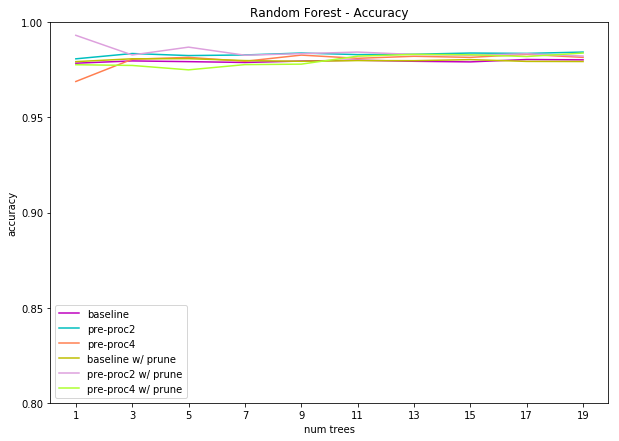

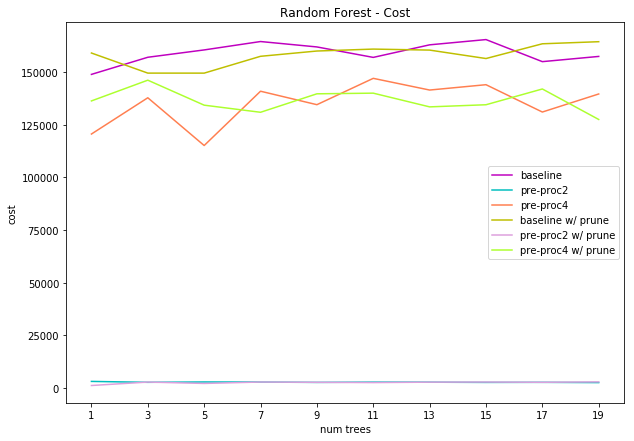

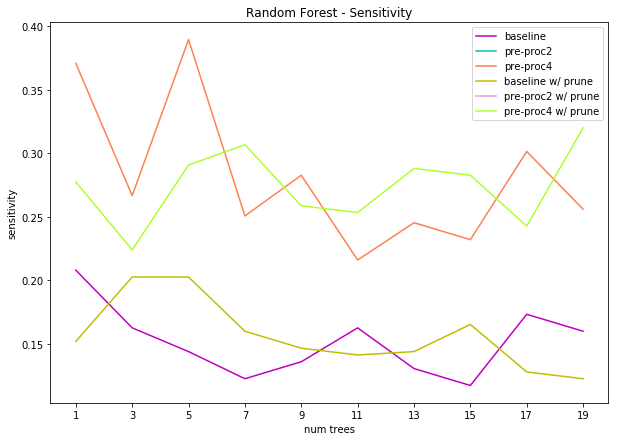

In [90]:
Ks = range(1,21,2)

plt.figure()
plt.title('Random Forest - Accuracy')
plt.plot(Ks, accurracies_RF_ntree_0,'m', label='baseline')
plt.plot(Ks, accurracies_RF_ntree_2,'c', label='pre-proc2')
plt.plot(Ks, accurracies_RF_ntree_4,'coral', label='pre-proc4')
plt.plot(Ks, accurracies_RF_ntree_0poda,'y', label='baseline w/ prune')
plt.plot(Ks, accurracies_RF_ntree_2poda[0:-3],'plum', label='pre-proc2 w/ prune')
plt.plot(Ks, accurracies_RF_ntree_4poda,'greenyellow', label='pre-proc4 w/ prune')
plt.legend()
plt.xlabel("num trees")
plt.ylabel("accuracy")
plt.xticks(np.arange(1, 21, step=2))
plt.yticks(np.arange(0.80, 1.01, step=0.05))
plt.show()

plt.figure()
plt.title('Random Forest - Cost')
plt.plot(Ks, costs_RF_ntree_0,'m', label='baseline')
plt.plot(Ks, costs_RF_ntree_2,'c', label='pre-proc2')
plt.plot(Ks, costs_RF_ntree_4,'coral', label='pre-proc4')
plt.plot(Ks, costs_RF_ntree_0poda,'y', label='baseline w/ prune')
plt.plot(Ks, costs_RF_ntree_2poda[0:-3],'plum', label='pre-proc2 w/ prune')
plt.plot(Ks, costs_RF_ntree_4poda,'greenyellow', label='pre-proc4 w/ prune')
plt.legend()
plt.xlabel("num trees")
plt.ylabel("cost")
plt.xticks(np.arange(1, 21, step=2))
plt.show()

plt.figure()
plt.title('Random Forest - Sensitivity')
plt.plot(Ks, sensitivities_RF_ntree_0,'m', label='baseline')
plt.plot(Ks, sensitivities_RF_ntree_2,'c', label='pre-proc2')
plt.plot(Ks, sensitivities_RF_ntree_4,'coral', label='pre-proc4')
plt.plot(Ks, sensitivities_RF_ntree_0poda,'y', label='baseline w/ prune')
plt.plot(Ks, sensitivities_RF_ntree_2poda[0:-3],'plum', label='pre-proc2 w/ prune')
plt.plot(Ks, sensitivities_RF_ntree_4poda,'greenyellow', label='pre-proc4 w/ prune')
plt.xlabel("num trees")
plt.ylabel("sensitivity")
plt.xticks(np.arange(1, 21, step=2))
plt.legend()
plt.show()

---2 c/poda---
[[    0     0]
 [  130 15643]]
Accurracy: 0.9917580675838458
Sensitivity: nan
Specificity: 0.9917580675838458
Cost: [ 1300 65000]
Confusion matrix, without normalization
[[    0     0]
 [  130 15643]]


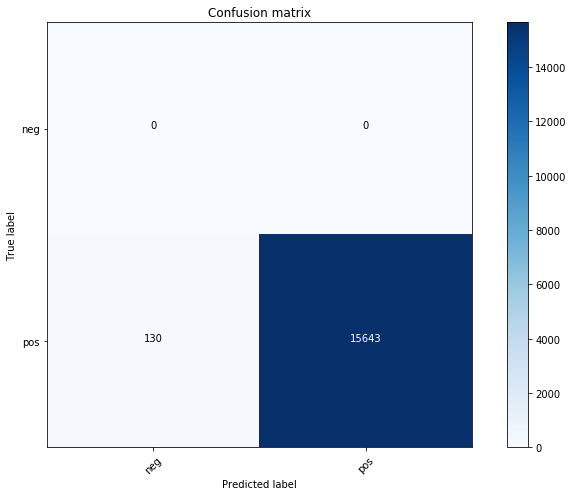

In [47]:
print("---2 c/poda---")
    
rf = RandomForestClassifier(n_estimators =1, max_depth=10)
model = rf.fit(X_preproc_2, Y_preproc_2)
predYClf = model.predict(X_preproc_2_test)
cmClf = metrics.confusion_matrix(Y_preproc_2_test, predYClf,labels=[1, 0])
accuracy = model.score(X_preproc_2_test, Y_preproc_2_test)
Sens, Spec, cost = compute_metrics(cmClf)
accurracies_RF_ntree_2poda.append(accuracy)
costs_RF_ntree_2poda.append(cost[0])
sensitivities_RF_ntree_2poda.append(Sens[0])

print(cmClf)
print("Accurracy:", accuracy)
print("Sensitivity:", Sens[0])
print("Specificity:", Spec[0])
print("Cost:", cost)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cmClf , classes=labels, title='Confusion matrix')
plt.show()